In [4]:
import astropy.units as u
import astropy.constants as const
import numpy as np
from scipy.ndimage import gaussian_filter as smooth
import matplotlib.pyplot as plt
import pandexo.engine.justplotit as jpi

from jwst_functions import homebrew_pandexo
from jwst_functions import actual_pandexo

# Context

In [5]:
# 
print('Depth of the satellite (ppm):')
print(((2.61*u.R_earth)  
            / (1.117*u.R_sun)).to(u.dimensionless_unscaled).value**2
                  * 1e6)
print('Depth of the planet (ppm):')
print(((0.8886*u.R_jup)
           / (1.117*u.R_sun)).to(u.dimensionless_unscaled).value**2
                  * 1e6)
print()
print('Depth of saturn (polar radius, ppm):')
print(((8.552*u.R_earth)
           /(1*u.R_sun)).to(u.dimensionless_unscaled).value**2
              * 1e6)
print('Depth of saturn (equitorial radius, ppm):')
print(((9.449*u.R_earth)
           /(1*u.R_sun)).to(u.dimensionless_unscaled).value**2
              * 1e6)

Depth of the satellite (ppm):
458.8949832966848
Depth of the planet (ppm):
6683.087668940855

Depth of saturn (polar radius, ppm):
6147.1530460132735
Depth of saturn (equitorial radius, ppm):
7504.302625480412


In [6]:
# Equilibrium temp of planet:
star_surface_flux = const.sigma_sb * (6157*u.K)**4
star_flux = star_surface_flux * 4*np.pi*(1.117*u.R_sun)**2
planet_surface_incoming_flux = star_flux / (4*np.pi*(1.64*u.AU)**2)
planet_outgoing_flux = planet_surface_incoming_flux / 4 # reradiates over full surface
planet_effective_temp = (planet_outgoing_flux / const.sigma_sb)**(1/4)
planet_effective_temp.to(u.K)

<Quantity 245.02314725 K>

# White light moon detection

If we aim to just detect the satellite, we can focus on the resolution of the white light curve. Here are two estimates for its precision using Pandeia and PandExo

In [7]:
# Pandeia implementation
observation_model = homebrew_pandexo(mag=14.168, mag_band='H',
                                     temp=6157, metal=0, logg=4.37, 
                                     transit_duration=19.13*u.hour,
                                     out_transit_duration=19.13*u.hour,
                                     Rp2Rs=((0.8886*u.R_jup)/(1.117*u.R_sun)).to(
                                             u.dimensionless_unscaled).value)
summary = observation_model.transit_summary()
summary

{'total depth error (ppm)': 9.09987538476698,
 'groups per integration': 52.0,
 'time per integration': <Quantity 12.00696 s>,
 'out transit total err (ppm)': 6.469082173384751,
 'in transit total err (ppm)': 6.486306468107826,
 'out transit indiv err (ppm)': 489.90218778041304,
 'in transit indiv err (ppm)': 491.2065798783408,
 'num integrations out of transit': 5735.0,
 'num integrations in transit': 5735.0}

In [8]:
# PandExo implementation
# Have to dig a little to turn the final products,
#  which are transmission spectra, into white light
#  curves
pandexo_model, pandexo_summary = actual_pandexo(hmag=14.168,
                                   temp=6157, metal=0, logg=4.37, 
                                   transit_duration=19.13*u.hour,
                                   Rp=0.8886*u.R_jup, Rs=1.117*u.R_sun)
pandexo_summary

Running Single Case for: NIRSpec Prism
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


{'total depth error (ppm)': 7.206823796183371,
 'groups per integration': 51.0,
 'time per integration': 11.76032,
 'out transit total err (ppm)': 5.120970908202888,
 'in transit total err (ppm)': 5.1393580405661785,
 'out transit indiv err (ppm)': 391.8797683701198,
 'in transit indiv err (ppm)': 393.28683458874946,
 'num integrations out of transit': 5856.0,
 'num integrations in transit': 5856.0}

# Planet atmosphere studies

Even if the goal is to just detect the moon, you get a transmission spectrum of the planet's atmosphere for free, so it's worth checking the resolution on that. Here is a PandExo estimate.

In [9]:
x,y,e = jpi.jwst_1d_spec(pandexo_model, R=5,
                         model=True, output_notebook=True,
                         plot=False, output_file=False,
                         x_range=[0.5,5.5])

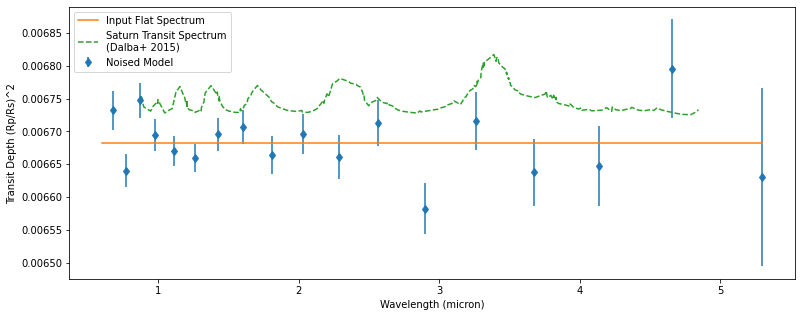

In [10]:
saturn = np.loadtxt('Dalba_2015_Saturn.csv', delimiter=',')
fig, ax = plt.subplots(figsize=(13,5))
ax.errorbar(x=x[0],y=y[0],yerr=e[0],
            ls='none', marker='d',
            label='Noised Model')
ax.plot(pandexo_model['FinalSpectrum']['wave'],
        pandexo_model['FinalSpectrum']['spectrum'],
        label='Input Flat Spectrum')
ax.plot(saturn[:,0],
        saturn[:,1],
        linestyle='--', label='Saturn Transit Spectrum\n(Dalba+ 2015)')
ax.set(xlabel='Wavelength (micron)', ylabel='Transit Depth (Rp/Rs)^2')
ax.legend()

In [11]:
# The features in the Saturn spectrum are ~50-90 ppm
# The median error on each (binned) point is:
np.median(e[0][(x[0]<5) & (x[0]>1)]) * 1e6

33.460628937796336